# Classification

## Objectives

*   Fit and evaluate a classification model to predict if it is a buy or sell entry.


## Inputs

* C:\Users\sunny\Desktop\Development\python\NeuralPricing\Input\USDJPY_prices.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Step 1: Load Data

In [7]:
# import sys
# sys.path.append('..')  # Add the parent directory to the path

import pandas as pd
import numpy as np
import os
#from data_processing import main #not sure if I need this but it works in the other script



In [8]:
# Go one level up from the current working directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))
input_folder = rf"{parent_directory}\inputs\USDJPY_prices.csv"
output_folder = rf"{parent_directory}\outputs"

#this is to ensure the data_processing.py script gets imported
data_path = rf"{parent_directory}\untracked_files\data_processing.py"
data_path = data_path.replace("\\", "/")
print(data_path)
%run "{data_path}"

# %run "C:\Users\sunny\Desktop\Development\python\NeuralPricing\jupyter_notebooks\data_processing.py"

#call on data_processing.py script main function to calculate all relevant data used in machine training.
#Note to drop date before using.
df = main(input_folder)
# in case the original dataframe is needed.
ori_df = df.copy()
df.drop(columns=['date'], inplace= True)
print(df.head(10))

c:/Users/sunny/Desktop/Development/python/NeuralPricing/classified_files/data_processing.py
c:\Users\sunny\Desktop\Development\python\NeuralPricing\inputs\USDJPY_prices.csv
        open     high      low    close       ma20       ma50      ma100  \
99   133.532  133.810  133.470  133.804  133.14950  132.15422  131.41518   
100  133.805  133.825  133.572  133.640  133.20960  132.20670  131.44406   
101  133.644  133.944  133.627  133.813  133.27620  132.27008  131.47374   
102  133.815  133.924  133.770  133.911  133.34225  132.33200  131.50365   
103  133.913  134.371  133.840  134.156  133.42340  132.40216  131.53578   
104  134.159  134.196  133.960  134.024  133.50055  132.46612  131.56582   
105  134.025  134.322  133.689  134.220  133.58905  132.53358  131.59877   
106  134.224  134.443  134.149  134.346  133.66840  132.60604  131.63309   
107  134.348  134.591  134.277  134.409  133.70445  132.68934  131.66780   
108  134.410  134.411  134.217  134.359  133.73520  132.76644  131.

In [9]:
#check which attributes are string content
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['bb_status', 'month', 'time', 'weekday_name', 'market_state_lag1', 'market_bb']


In [10]:
#output the data to a csv file for further external analysis
df.to_csv(rf"{output_folder}\usdjpy_historical_prices.csv",index=False)

---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [42]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder

# this defines the pipeline for cleaning
# make sure the variables are updated accordingly
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['bb_status', 'month', 'time', 'weekday_name', 'market_state_lag1', 'market_bb'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.4, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['bb_status', 'month', 'time',
                                           'weekday_name', 'market_state_lag1',
                                           'market_bb'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.4))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [43]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimisation

In [44]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

In [45]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['trade_close_4_hr'], axis=1),
    df['trade_close_4_hr'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(3408, 29) (3408,) (852, 29) (852,)


## Handle Target Imbalance

In [46]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3408, 10) (3408,) (852, 10) (852,)


c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
c:\Users\sunny\anaconda3\envs\myenv3811\lib\site-packages\feature_engine\selection\smart_correlation_se

In [47]:
print(df.columns.tolist())

['open', 'high', 'low', 'close', 'ma20', 'ma50', 'ma100', 'upper_bb20_2', 'lower_bb20_2', 'bb_status', 'lagged_close_1', 'pl_close_1_hr', 'trade_close_1_hr', 'lagged_close_4', 'pl_close_4_hr', 'trade_close_4_hr', 'month', 'time', 'hr', 'weekday', 'weekday_name', 'up_bb20_low_bb20_diff', 'close_ma20_diff', 'close_ma50_diff', 'close_ma100_diff', 'ma20_ma50_diff', 'ma50_ma100_diff', 'bb_slope_lag1', 'market_state_lag1', 'market_bb']


In [48]:
print(X_train.head(10))

      lower_bb20_2  bb_status  trade_close_1_hr  month  time  hr  \
966     135.254963          0                 1      0     0   4   
3988    145.055512          0                 0      1     1  22   
191     132.219127          0                 1      2     2  21   
3469    139.166546          0                 0      3     3   7   
2634    139.028029          0                 1      4     4  12   
2505    138.284951          0                 1      5     5   3   
1858    133.898390          0                 0      6     6  16   
3112    144.146152          0                 0      4     7  10   
1809    131.756510          1                 1      6     8  18   
2963    141.185522          2                 0      4     9   5   

      weekday_name  up_bb20_low_bb20_diff  close_ma100_diff  ma50_ma100_diff  
966              0               1.738473           1.26923          0.28531  
3988             1               0.624076          -0.22820          0.10128  
191           

Check Train Set Target distribution

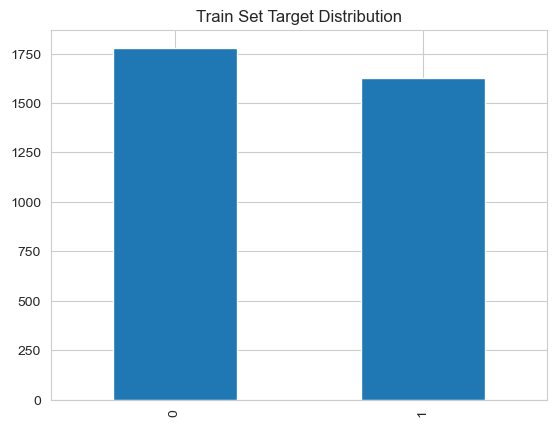

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [50]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3562, 10) (3562,) (852, 10) (852,)


Check Train Set Target distribution after resampling

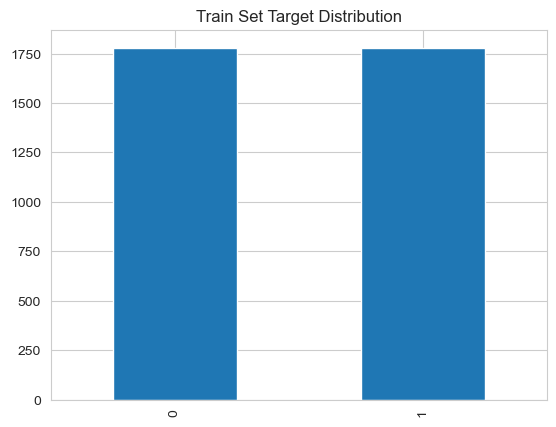

In [51]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [52]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Quick GridSearch CV - Binary Classifier

In [53]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [54]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.696629,0.72879,0.753501,0.01878
5,ExtraTreesClassifier,0.691011,0.728232,0.752809,0.022199
4,GradientBoostingClassifier,0.63764,0.70575,0.764706,0.040718
2,DecisionTreeClassifier,0.682584,0.704087,0.72549,0.014286
1,XGBClassifier,0.615169,0.692291,0.722689,0.039509
0,LogisticRegression,0.581461,0.675437,0.722689,0.04879
6,AdaBoostClassifier,0.55618,0.619279,0.683473,0.051575


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [55]:
models_search = {
    "RandomForestClassifier":RandomForestClassifier	(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__max_features': ['auto', 'sqrt', 'log2'],
    }
}

Extensive GridSearch CV - Binary Classifier

In [56]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Check results

In [57]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__n_estimators
26,RandomForestClassifier,0.716292,0.743962,0.772472,0.017918,20,log2,200
23,RandomForestClassifier,0.716292,0.743962,0.772472,0.017918,20,sqrt,200
20,RandomForestClassifier,0.716292,0.743962,0.772472,0.017918,20,auto,200
2,RandomForestClassifier,0.710674,0.737219,0.7507,0.014075,None,auto,200
5,RandomForestClassifier,0.710674,0.737219,0.7507,0.014075,None,sqrt,200
8,RandomForestClassifier,0.710674,0.737219,0.7507,0.014075,None,log2,200
25,RandomForestClassifier,0.707865,0.732164,0.75,0.017039,20,log2,100
22,RandomForestClassifier,0.707865,0.732164,0.75,0.017039,20,sqrt,100
19,RandomForestClassifier,0.707865,0.732164,0.75,0.017039,20,auto,100
4,RandomForestClassifier,0.696629,0.72879,0.753501,0.01878,None,sqrt,100


Get best model name programmatically

In [58]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [59]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 20,
 'model__max_features': 'auto',
 'model__n_estimators': 200}

Define the best clf pipeline

In [60]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        random_state=0))])

## Assess feature importance

In [61]:
X_train.head(3)

,lower_bb20_2,bb_status,trade_close_1_hr,month,time,hr,weekday_name,up_bb20_low_bb20_diff,close_ma100_diff,ma50_ma100_diff
0,135.254963,0,1,0,0,4,0,1.738473,1.26923,0.28531
1,145.055512,0,0,1,1,22,1,0.624076,-0.22820,0.10128
2,132.219127,0,1,2,2,21,2,0.550646,-0.02822,-0.27234


* With the current model, we can assess with `.features_importances_`

* These are the 5 most important features in descending order. The model was trained on them: 
['close_ma100_diff', 'ma50_ma100_diff', 'lower_bb20_2', 'up_bb20_low_bb20_diff', 'bb_status']


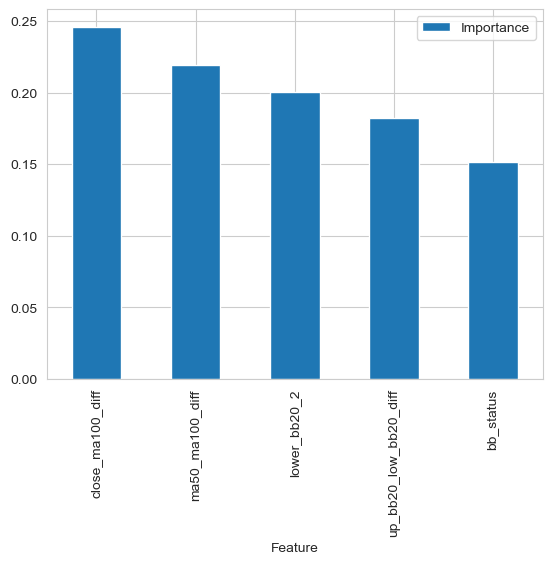

In [62]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [63]:
# Assuming pipeline_clf['feat_selection'].get_support() returns the boolean mask
feature_selection_mask = pipeline_clf['feat_selection'].get_support()

# Convert the boolean mask to a list
feature_selection_list = feature_selection_mask.tolist()

print("Feature selection mask as a list:")
print(feature_selection_list)

# Or, you can directly print specific elements
print("First 10 elements of the feature selection mask:")
print(feature_selection_mask[:10])

Feature selection mask as a list:
[True, True, False, False, False, False, False, True, True, True]
First 10 elements of the feature selection mask:
[ True  True False False False False False  True  True  True]


In [64]:
df_feature_importance

,Feature,Importance
3,close_ma100_diff,0.245988
4,ma50_ma100_diff,0.218987
0,lower_bb20_2,0.200770
2,up_bb20_low_bb20_diff,0.182433
1,bb_status,0.151822


## Evaluate Pipeline on Train and Test Sets

In [65]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [66]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Sell', 'Buy'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual Sell Actual Buy
Prediction Sell        1781          0
Prediction Buy            0       1781


---  Classification Report  ---
              precision    recall  f1-score   support

        Sell       1.00      1.00      1.00      1781
         Buy       1.00      1.00      1.00      1781

    accuracy                           1.00      3562
   macro avg       1.00      1.00      1.00      3562
weighted avg       1.00      1.00      1.00      3562
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual Sell Actual Buy
Prediction Sell         302        107
Prediction Buy          120        323


---  Classification Report  ---
              precision    recall  f1-score   support

        Sell       0.74      0.72      0.73       422
         Buy       0.73      0.75      0.74       430

    accuracy                           0.73       852
   macro avg       0.73      0.73      0.73       852
w

# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [67]:
best_features

['close_ma100_diff',
 'ma50_ma100_diff',
 'lower_bb20_2',
 'up_bb20_low_bb20_diff',
 'bb_status']

In [68]:
#it is good to see some of features as expected are being picked above.
#However, I think these should drive the model.
best_features = ['close_ma20_diff',
 'close_ma100_diff',
 'up_bb20_low_bb20_diff',
 'ma50_ma100_diff',
 'hr',
 'bb_status',
 'market_state_lag1']

New Pipeline for DataCleaning And FeatureEngineering

In [69]:
#Note: variables need to be updated as required!
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['bb_status', 'market_state_lag1'])),


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [70]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['trade_close_4_hr'], axis=1),
    df['trade_close_4_hr'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(3408, 29) (3408,) (852, 29) (852,)


We filter only the most important variables

In [72]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(3408, 7) (3408,) (852, 7) (852,)


,close_ma20_diff,close_ma100_diff,up_bb20_low_bb20_diff,ma50_ma100_diff,hr,bb_status,market_state_lag1
966,0.18180,1.26923,1.738473,0.28531,4,inside_bb,bearish
3988,0.10145,-0.22820,0.624076,0.10128,22,inside_bb,flat
191,-0.03445,-0.02822,0.550646,-0.27234,21,inside_bb,flat


## Handle Target Imbalance

In [73]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3408, 7) (3408,) (852, 7) (852,)


Check Train Set Target distribution

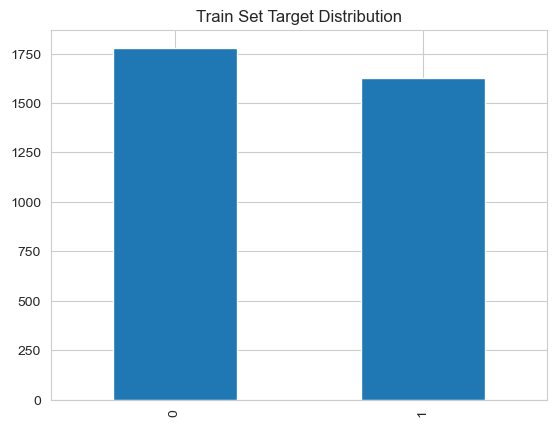

In [74]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [75]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3562, 7) (3562,) (852, 7) (852,)


Check Train Set Target distribution after SMOTE

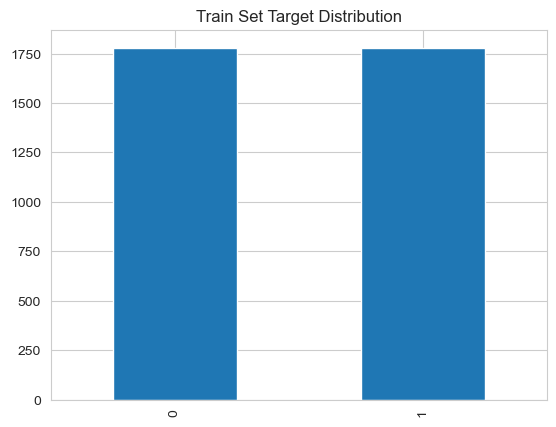

In [76]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [77]:
models_search   # XGBClassifier

{'RandomForestClassifier': RandomForestClassifier(random_state=0)}

And the best parameters from the last GridCV search 

In [78]:
best_parameters

{'model__max_depth': 20,
 'model__max_features': 'auto',
 'model__n_estimators': 200}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [79]:
params_search = {
                 
                     "RandomForestClassifier": {
        'model__n_estimators': [100],
        'model__max_depth': [20],
        'model__max_features': ['auto'],
        }
                     

}
params_search


{'RandomForestClassifier': {'model__n_estimators': [100],
  'model__max_depth': [20],
  'model__max_features': ['auto']}}

GridSearch CV

In [80]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)



Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [81]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__n_estimators
0,RandomForestClassifier,0.792135,0.81472,0.865169,0.02699,20,auto,100


Define the best clf pipeline

In [82]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, random_state=0))])

## Assess feature importance

* These are the 7 most important features in descending order. The model was trained on them: 
['close_ma20_diff', 'up_bb20_low_bb20_diff', 'close_ma100_diff', 'ma50_ma100_diff', 'hr', 'bb_status', 'market_state_lag1']


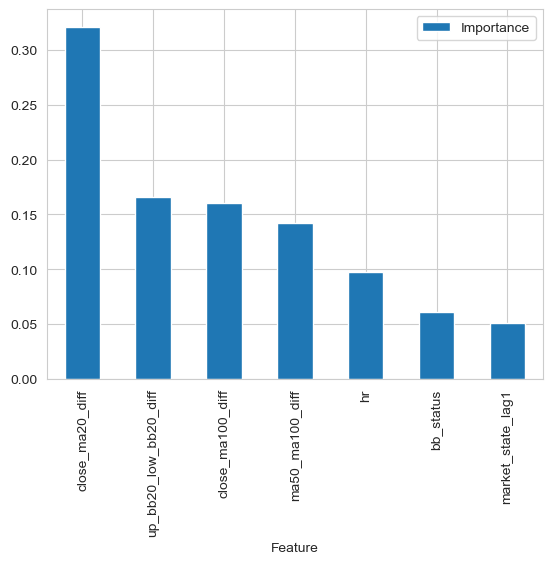

In [84]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for trade, on train and test set.
* 80% Precision for trade on train and test set. 

In [85]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['sell', 'buy'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual sell Actual buy
Prediction sell        1781          0
Prediction buy            0       1781


---  Classification Report  ---
              precision    recall  f1-score   support

        sell       1.00      1.00      1.00      1781
         buy       1.00      1.00      1.00      1781

    accuracy                           1.00      3562
   macro avg       1.00      1.00      1.00      3562
weighted avg       1.00      1.00      1.00      3562
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual sell Actual buy
Prediction sell         340         83
Prediction buy           82        347


---  Classification Report  ---
              precision    recall  f1-score   support

        sell       0.80      0.81      0.80       422
         buy       0.81      0.81      0.81       430

    accuracy                           0.81       852
   macro avg       0.81      0.81      0.81       852
w

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [6]:
import joblib
import os

version = 'v1'
file_path = f'{parent_directory}/outputs/predict_trade/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\sunny\\Desktop\\Development\\python\\NeuralPricing/outputs/predict_trade/v1'


## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [7]:
print(X_train.shape)
X_train.head()

NameError: name 'X_train' is not defined

In [90]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [91]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [92]:
print(X_test.shape)
X_test.head()

(852, 7)


,close_ma20_diff,close_ma100_diff,up_bb20_low_bb20_diff,ma50_ma100_diff,hr,bb_status,market_state_lag1
1412,0.13965,-0.58064,1.092392,0.09966,14,0,1
916,-0.02260,0.20090,0.562292,0.20136,2,0,1
893,0.06765,0.55001,0.596813,0.11089,3,0,1
4119,0.11200,0.79482,0.459233,0.34004,9,0,0
1936,0.16745,-0.15861,0.863726,-0.05071,5,0,1


In [93]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [94]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [95]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['bb_status', 'market_state_lag1']))])

In [96]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/usdjpy_pipeline_data_cleaning.pkl")

['c:\\Users\\sunny\\Desktop\\Development\\python\\NeuralPricing/outputs/v1/usejpy_pipeline_data_cleaning.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [97]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, random_state=0))])

In [98]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/usdjpy_pipeline_model.pkl")

['c:\\Users\\sunny\\Desktop\\Development\\python\\NeuralPricing/outputs/v1/usdjpy_pipeline_model.pkl']

## Feature Importance plot

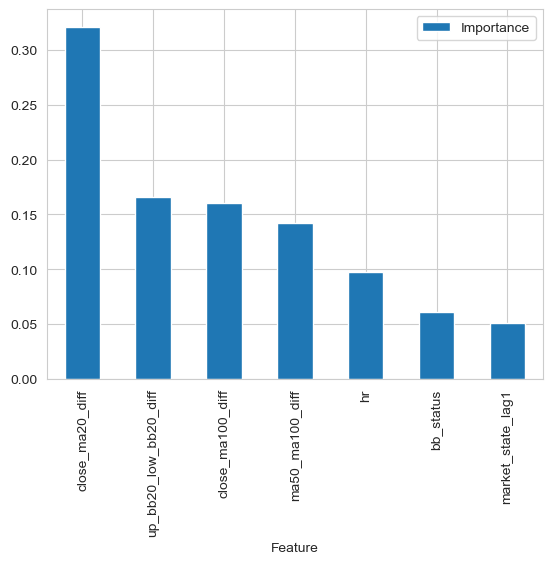

In [99]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

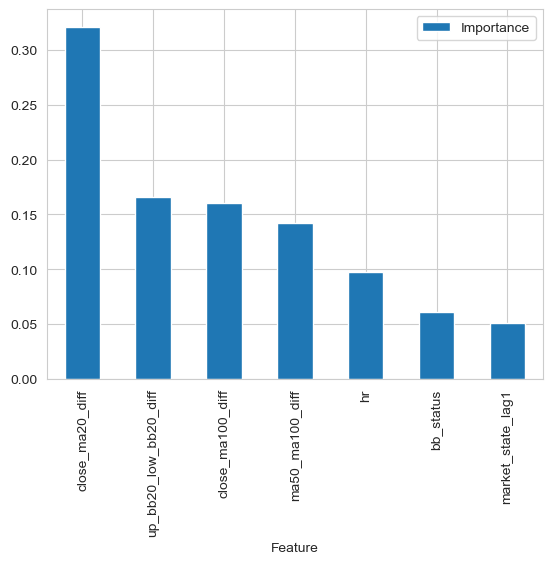

In [100]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

# Tesing the model

In [ ]:
print(X_test[:1])

t = X_test[:1]
t.iloc[0, t.columns.get_loc('close_ma20_diff')] = -0.0637
t.iloc[0, t.columns.get_loc('trade_close_1_hr')] = 1
print(t.iloc[0])

y_pred = pipeline_clf.predict(t)
print(y_pred)

In [ ]:
import joblib
import os
y_pred = pipeline_clf.predict(X_test)
y_df = pd.DataFrame(y_pred)
print(y_df)
version = 'v2'

y_df.to_csv(f"{output_folder}/y_pred.csv", index=False)

In [ ]:
print(y_test)

1412    1
916     1
893     1
4119    0
1936    0
       ..
4171    1
2911    0
3572    0
3432    0
3425    1
Name: trade_close_4_hr, Length: 852, dtype: int64


---